In [85]:
import lxml.etree
import glob
import os
import math
from PIL import Image, ImageDraw
import numpy as np
import ntpath
from shutil import copyfile
import matplotlib.pyplot as plt
import pandas as pd
def get_xml_data(xml_path):
    def parse_xml(xml):
        if not len(xml):
            return {xml.tag: xml.text}
        result = {}
        for child in xml:
            child_result = parse_xml(child)
            if child.tag != 'object':
                result[child.tag] = child_result[child.tag]
            else:
                if child.tag not in result:
                    result[child.tag] = []
                result[child.tag].append(child_result[child.tag])
        return {xml.tag: result}

    annotation_xml = lxml.etree.fromstring(open(xml_path).read())
    annotation = parse_xml(annotation_xml)['annotation']
    boxes = []
    for obj in annotation['object']:
        box = {k:float(i) for k,i in obj['robndbox'].items()}
        class_name = obj['name']
        size = annotation['size']
        angle = math.degrees(float(box['angle']))
        
        
        box['img_width'] = float(size['width'])
        box['img_height'] = float(size['height'])
        box['angle'] = angle
        box['class'] = class_name
        boxes.append(box)
    return boxes

def rotate_around_point(origin, radians, point):
    """Rotate a point around a given point.

    I call this the "low performance" version since it's recalculating
    the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
    It's more readable than the next function, though.
    """
    x, y = point
    ox, oy = origin

    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

    return qx, qy

def get_points_and_angle(box):

    cx, cy = box['cx'], box['cy']
    w2, h2 = box['w']/2, box['h']/2
    xlt = cx - w2; ylt = cy - h2
    xrt = cx + w2; yrt = cy - h2

    xlb = cx - w2; ylb = cy + h2
    xrb = cx + w2; yrb = cy + h2

    xlt, ylt = rotate_around_point((cx, cy), math.radians(box['angle']), (xlt, ylt))
    xrt, yrt = rotate_around_point((cx, cy), math.radians(box['angle']), (xrt, yrt))
    xlb, ylb = rotate_around_point((cx, cy), math.radians(box['angle']), (xlb, ylb))
    xrb, yrb = rotate_around_point((cx, cy), math.radians(box['angle']), (xrb, yrb))
    return (xlt, ylt, xrt, yrt, xrb, yrb, xlb, ylb, )

In [86]:
def angle_diff(a1, a2):
    diff = a1-a2
    diff = abs((diff + 180) % 360 - 180)
    return diff

def xywha2xy4(xywha):  # a represents the angle(degree), clockwise, a=0 along the X axis
    x, y, w, h, a = xywha
    corner = np.array([[-w / 2, -h / 2], [w / 2, -h / 2], [w / 2, h / 2], [-w / 2, h / 2]])
    a = np.deg2rad(a)
    transform = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    return transform.dot(corner.T).T + [x, y]


def xy42xywha(xy4, flag=0):  # bbox(4x2) represents a rectangle
    # flag=0, 0 <= a < 180
    # flag=1, 0 <= a < 180, w >= h
    # flag=2, -45 <= a < 45
    x, y = np.mean(xy4, axis=0)
    diff01 = xy4[0] - xy4[1]
    diff03 = xy4[0] - xy4[3]
    w = np.sqrt(np.square(diff01).sum())
    h = np.sqrt(np.square(diff03).sum())
    if w >= h:
        a = np.rad2deg(np.arctan2(diff01[1], diff01[0]))
    else:
        a = np.rad2deg(np.arctan2(diff03[1], diff03[0])) + 90
    if flag > 0:
        if w < h:
            w, h = h, w
            a += 90
    a = (a % 180 + 180) % 180
    if flag > 1:
        if 45 <= a < 135:
            w, h = h, w
            a -= 90
        elif a >= 135:
            a -= 180
    return np.stack([x, y, w, h, a])


In [94]:
(178-360)%360

178

In [122]:
xml_files = list(glob.iglob(os.path.join('/home/mde/python/pytorch-rotation-decoupled-detector/images-gas/artelab-dataset', '*.xml')))

for i, xml_file in enumerate(xml_files):
    jpg_file = xml_file[:-4]+ '.jpg'
    xml_filename = ntpath.basename(xml_file)
    jpg_filename = xml_filename[:-4] + '.jpg'
    txt_filename = xml_filename[:-4] + '.txt'

    boxes = get_xml_data(xml_file)
    for box in boxes:
        points = get_points_and_angle(box)
        default_angle = box['angle']
        
        if box['class'] == 'register':
            if float(box['angle']) < 180:
                box['class'] = 'register_0-179'
            else:
                box['class'] = 'register_180-360'
                
                
            
        xywha = box['cx'], box['cy'], box['w'], box['h'], 360-box['angle']
        xywha = (float(i) for i in xywha)
        xy4 = xywha2xy4(xywha)
        back_xywha = xy42xywha(xy4)
        
        label = ' '.join([str(x) for x in points]) + f" {box['class']} {box['angle']}"
        
        pred_angle = back_xywha[-1]
        if box['class'] == 'register_180-360':
#             print(float(box['angle']), box['class'])
            pred_angle =  360-pred_angle
        elif box['class'] == 'register_0-179':
            pred_angle = 180-pred_angle
#     #     print('pred angle', pred_angle)
        if box['class'] in {'register_180-360', 'register_0-179'}:
            if angle_diff(pred_angle, default_angle) > 3:
                print(pred_angle, default_angle)
                print('____')


In [133]:
(180-(0+89))%360

91

In [60]:
from shapely.geometry import Polygon
import cv2 as cv
def xywha2xy4(xywha):  # a represents the angle(degree), clockwise, a=0 along the X axis
    x, y, w, h, a = xywha
    corner = np.array([[-w / 2, -h / 2], [w / 2, -h / 2], [w / 2, h / 2], [-w / 2, h / 2]])
    a = np.deg2rad(a)
    transform = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    return transform.dot(corner.T).T + [x, y]


def xy42xywha(xy4, flag=0):  # bbox(4x2) represents a rectangle
    # flag=0, 0 <= a < 180
    # flag=1, 0 <= a < 180, w >= h
    # flag=2, -45 <= a < 45
    x, y = np.mean(xy4, axis=0)
    diff01 = xy4[0] - xy4[1]
    diff03 = xy4[0] - xy4[3]
    w = np.sqrt(np.square(diff01).sum())
    h = np.sqrt(np.square(diff03).sum())
    if w >= h:
        a = np.rad2deg(np.arctan2(diff01[1], diff01[0]))
    else:
        a = np.rad2deg(np.arctan2(diff03[1], diff03[0])) + 90
    if flag > 0:
        if w < h:
            w, h = h, w
            a += 90
    a = (a % 180 + 180) % 180
    if flag > 1:
        if 45 <= a < 135:
            w, h = h, w
            a -= 90
        elif a >= 135:
            a -= 180
    return np.stack([x, y, w, h, a])


def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

def get_xy4_from_row(row):
    coords = np.array([row['x1'], row['y1'], row['x2'], row['y2'], row['x3'], row['y3'], row['x4'], row['y4']])
    coords = coords.reshape([4, 2]).astype(np.float32)
    coords = cv.boxPoints(cv.minAreaRect(coords))
    return coords
    if x2 > x3:
        x1, x3, y1, y3 = x3,x1, y3, y1
#         x3, x4, y3, y4 = x4, x3, y4, y3
    return np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y3]]).astype(np.float)

In [61]:
def get_angle(coords, c):
    (x1,y1),(x2,y2),(x3,y3) = coords[0], coords[1], coords[2]
    v1 = np.array([x1-x2, y1-y2])
    v2 = np.array([x2-x3, y2-y3])
    if np.sqrt(np.sum(v1**2)) > np.sqrt(np.sum(v2**2)):
        x = v1[0]; y = v1[1]
    else:
        x = v2[0]; y = v2[1]

    a = math.degrees(np.arctan(y/x))
#      if c <= 45
#         final_angle = 0+a
#     if c <= 45:
#         final_angle = 0+a
#     elif c >= 45 and c < 90:
#         final_angle = 45+a
#     elif c >=90 and c < 135:
#         final_angle = 90+a
#     elif c >= 135 and c < 180:
#         final_angle = 135+a
#     elif c >= 180 and c < 225:
#         final_angle = 180+a
#     elif c >= 225 and c < 270:
#         final_angle = 225+a
#     elif c >= 270 and c < 315:
#         final_angle = 270+a
#     elif c >= 315:
#         final_angle = 315+a
#     else:
#         print('nope')
    return a

In [86]:
ious = []
a_diffs = []
angle_pairs = []
for fname, gt_row in df_gt.iterrows():
    preds = df_pred[df_pred['img_name'] == fname]
    if len(preds):
        for _, pred_row in preds.iterrows():
            if pred_row.w + pred_row.h != 0:
                pred_bb = get_xy4_from_row(pred_row)
                gt_bb = get_xy4_from_row(gt_row)
                iou = calculate_iou(pred_bb, gt_bb)
                
                gt_angle = float(gt_row['angle'])
                pred_angle_from_bb = int(pred_row['bb_angle'])
                pred_angle_from_class = int(pred_row['angle_class_degrees'])
                
                final_angle = get_angle(pred_bb, pred_row['angle_class_degrees'])
                print(gt_angle, final_angle, pred_row['bb_angle'], pred_row['angle_class_degrees'])
                angle_pairs.append([gt_angle, pred_angle_from_bb, pred_angle_from_class, 
                                    pred_row['w'], pred_row['h'], pred_row['x1'], pred_row['x2']])
                
                
#                 x,y,w,h, gt_angle_bb = xy42xywha(gt_bb)
#                 print(gt_angle, gt_angle_bb)
                
                
#                 pred_angle_from_class = int(pred_row['angle_class_degrees'])
#                 t = 20
#                 if angle_diff(pred_angle_from_bb,pred_angle_from_class) < t:
#                     pred_angle = pred_angle_from_bb
#                 else:
#                     pred_angle = (pred_angle_from_class + (pred_angle_from_bb % t))%360
                
                a_diff = angle_diff(final_angle, gt_angle)
                ious.append(iou)
                a_diffs.append(a_diff)


265.46194620332034 -87.3290501993555 92.67095456450198 85.0
265.46194620332034 0.20384990394551308 0.2038979560136624 0.0
265.46194620332034 0.23136289309810293 0.2313974087131498 175.0
265.46194620332034 -0.084736394060236 179.91527398216158 180.0
265.46194620332034 -1.903276608453658 178.09676851415009 0.0
265.46194620332034 -3.046349747190312 176.95359801617383 175.0
0.0 2.3291792440087384 2.329181039950356 355.0
0.0 7.357839212642808 7.357844691240757 345.0
353.6974466534671 5.552666745672158 5.5526731897003 355.0
353.6974466534671 -89.2098179193994 90.79008635632788 85.0
353.6974466534671 0.9203708721452742 0.9202881323497252 175.0
353.6974466534671 0.9203708721452742 0.9202881323497252 355.0
353.6974466534671 0.9203708721452742 0.9202881323497252 170.0
353.6974466534671 -86.52189259418925 93.47814323667058 85.0
353.6974466534671 0.9203708721452742 0.9202881323497252 0.0
353.6974466534671 0.9203708721452742 0.9202881323497252 350.0
353.6974466534671 0.9203708721452742 0.9202881323

44.11775022507339 -47.26615215091718 132.73385065747078 45.0
44.11775022507339 -41.97730786523911 138.022695718391 220.0
288.0 72.94786833584023 72.9478711158398 285.0
0.0 -1.988974991969808 178.01102233295092 0.0
2.0 0.9909064491474076 0.9909101685877032 355.0
2.0 2.8587549730979154 2.858756145660948 0.0
34.0 -36.182626599819066 143.8173902444828 30.0
34.0 -51.22126539736686 128.7787428454368 45.0
352.55153106320546 5.720437536028827 5.7204004420370325 355.0
352.55153106320546 83.04976592961327 83.04976153309178 275.0
352.55153106320546 86.42032085104199 86.42031001185194 85.0
91.0 87.03490127255974 87.03489813939512 90.0
91.0 88.6531233510975 88.65312436118501 80.0
170.0 8.329815258896996 8.329821091509018 170.0
29.220847551671984 -30.109669767234365 149.89034394892957 30.0
29.220847551671984 -60.01098461383749 119.9890102856378 45.0
152.9797312999298 25.88186292571922 25.881862715412524 150.0
152.9797312999298 27.764445768535033 27.764449641252128 330.0
152.9797312999298 53.83239207

10.886198107485642 -9.914968122794493 170.08503355580154 10.0
20.05352282957881 -21.19929867417004 158.80069985473904 10.0
20.05352282957881 -72.31610315837072 107.68389442086392 60.0
20.05352282957881 -18.455539967589633 161.5444576537609 175.0
20.05352282957881 -81.25737402724019 98.74261655264536 240.0
20.05352282957881 -76.54840938700161 103.45157384884884 55.0
20.05352282957881 -19.991673417587595 160.0083288256269 200.0
20.05352282957881 -80.61976903803033 99.38022056029688 90.0
20.05352282957881 -69.93552268543282 110.06447643580752 240.0
20.05352282957881 -74.65973913808803 105.34025756935432 85.0
20.05352282957881 -82.24407681511856 97.7559190737253 270.0
20.05352282957881 -13.324222042286863 166.6757901665029 10.0
20.05352282957881 -77.78588940044618 102.21411415732206 280.0
20.05352282957881 -79.07743036117141 100.922559552089 55.0
20.05352282957881 -13.324222042286863 166.6757901665029 5.0
20.05352282957881 -78.05350304231645 101.94649492317431 85.0
20.05352282957881 -13.32

54.0 -40.437650037629425 139.56236002703315 40.0
54.0 -54.220363895879025 125.7796380589674 60.0
339.94645957032736 18.67695591746123 18.67696474496259 340.0
339.94645957032736 65.05185546660367 65.05184542174891 290.0
339.94645957032736 -79.09553036247193 100.90445212446218 75.0
278.0 81.81915025628456 81.81915419710691 275.0
347.394910907028 12.214396556882537 12.214396689151044 345.0
350.832657677813 8.886899147981575 8.88689743515448 350.0
350.832657677813 9.406897671193924 9.406895906989943 355.0
359.0 -0.33476285910667813 179.6652288937023 355.0
359.0 1.2003231440294662 1.2003437392092169 345.0
273.0 89.70251361517826 89.70250894954813 270.0
273.0 88.19041218577499 88.19041385735937 265.0
265.0 -87.08612086114567 92.91387254036948 265.0
187.93015680291 -7.36486747729875 172.6351427124025 185.0
270.6185663594977 87.26079611897957 87.26079329031074 270.0
270.6185663594977 4.406976790709743 4.406973762937383 0.0
131.20733508495852 47.11971631020669 47.119712660243465 130.0
131.20733

239.67884542243328 -42.969560181818125 137.03042828670357 40.0
275.0 82.83022315912156 82.83022751460248 275.0
358.0 -0.23306222281926095 179.76691738833244 0.0
278.0 84.45431237015636 84.45431241477866 275.0
310.72561201865534 47.336096703112695 47.33609604767673 310.0
310.72561201865534 42.415905047696896 42.41590583909749 315.0
310.72561201865534 47.336096703112695 47.33609604767673 305.0
310.72561201865534 47.336096703112695 47.33609604767673 300.0
202.0 -21.356053223169127 158.64394522086002 200.0
225.0 -46.81139815597773 133.1885465847457 225.0
155.0 22.342166907231594 22.34216202224229 155.0
29.999999999999996 -28.889439396538663 151.11055369167718 25.0
29.999999999999996 -33.598660168871106 146.401335075105 5.0
29.999999999999996 -35.35553508756013 144.64446260589995 10.0
12.032113697747288 -8.794650613051383 171.20534776226776 5.0
12.032113697747288 -77.02086040208057 102.97914231483183 85.0
199.57179976327566 -20.326207545398358 159.67377269780303 200.0
2.291831180523293 -1.4

33.80450991271857 -31.518362132603645 148.48167064154222 40.0
33.80450991271857 -53.66532906354544 126.33466324241935 230.0
33.80450991271857 -35.300343743971844 144.6996562450388 30.0
33.80450991271857 -33.751161217564565 146.248853766161 220.0
33.80450991271857 -52.295964927417096 127.70402640245196 55.0
33.80450991271857 -52.511713527824874 127.48828494259249 230.0
33.80450991271857 -52.770533301138755 127.22946575746874 65.0
33.80450991271857 -53.102384872152996 126.89759611279914 50.0
33.80450991271857 -35.4289971871782 144.57102115442376 20.0
33.80450991271857 -51.51932460746246 128.4806595153259 45.0
33.80450991271857 -53.102384872152996 126.89759611279914 265.0
96.00000000000001 83.05950577936972 83.05949950826539 95.0
185.0 -2.080102522102472 177.91988371136875 180.0
184.0 -2.855997711107346 177.14400620342673 180.0
346.2489953167664 13.159564110644427 13.159574562816031 345.0
291.24504698420736 68.80483950985057 68.80485228122694 290.0
291.24504698420736 22.23341492771936 22.

10.313240312354818 -89.64623968660652 90.35375933373626 65.0
10.313240312354818 86.83205148439953 86.8320537049799 110.0
10.313240312354818 -87.66415977060385 92.3358369798027 260.0
10.313240312354818 -89.64623968660652 90.35375933373626 60.0
10.313240312354818 -89.64623968660652 90.35375933373626 250.0
10.313240312354818 88.47061386628559 88.47061668957224 270.0
115.0 64.32862039576935 64.32862982615589 115.0
356.56223562912123 2.7140548542102563 2.7140575440719203 355.0
273.0 88.17464127898143 88.17463379099922 270.0
146.0 31.63086559351751 31.63085678056578 150.0
146.0 52.46103693927797 52.46104212591735 130.0
206.26480624709637 -26.388432443249677 153.61154047311345 205.0
261.84171237478625 -81.79950663223161 98.20049787478968 260.0
203.0 -22.819310262270346 157.18069837743047 200.0
170.1684651538545 9.81369349287613 9.813683309663077 175.0
170.1684651538545 79.94810189542962 79.9481871489694 270.0
170.1684651538545 13.645142749308143 13.645125634304549 170.0
90.0 89.87177936318952

314.1633587894403 46.183218827822486 46.1832163725411 310.0
348.5408264972897 12.306548615390703 12.306546757388531 345.0
348.0 11.612598834396469 11.61260427205525 345.0
348.0 12.764062006754838 12.76406083352245 335.0
176.0 3.558724925515281 3.5587304003034888 175.0
170.0 8.90669815883815 8.906712685521569 170.0
87.66254265501595 -87.50712006120692 92.49288377979218 85.0
271.19152415462855 88.6732587487707 88.67325985915483 270.0
32.0 -33.73063649910868 146.26937435834378 30.0
32.0 -34.400613169889816 145.59938579383504 20.0
304.4230762722163 54.85541780943388 54.85542506049964 305.0
304.4230762722163 34.87884935519577 34.87886634451516 325.0
304.4230762722163 34.87884935519577 34.87886634451516 330.0
304.4230762722163 35.88635689928601 35.886350611139534 315.0
259.73236825201207 -77.08705859551632 102.91294807705584 255.0
351.9785732680746 8.083601453470022 8.083604069063654 350.0
355.41632003885957 3.934553950161117 3.9345575722387593 355.0
355.41632003885957 11.936728022780363 11.

78.49521793292278 -73.07230072213952 106.9276798299187 75.0
78.49521793292278 -10.789596897903076 169.2104064538089 0.0
78.49521793292278 -8.20654741985119 171.79346913451843 355.0
78.49521793292278 -13.56082747909892 166.43912384090245 175.0
78.49521793292278 -76.93854296220357 103.06149644497168 265.0
78.49521793292278 -8.627666148222911 171.37232628507297 185.0
78.49521793292278 -12.575280700737563 167.42473775932717 180.0
78.49521793292278 -74.5901600010131 105.4098464971256 60.0
78.49521793292278 -75.53791022005491 104.46207549810948 260.0
78.49521793292278 -13.504004574072646 166.49599342418048 195.0
78.49521793292278 -13.504004574072646 166.49599342418048 355.0
78.49521793292278 -13.504004574072646 166.49599342418048 20.0
84.22479588423101 -83.69658484401349 96.30340631796224 85.0
84.22479588423101 88.54223522992234 88.54223670528643 90.0
84.22479588423101 -8.299351761425092 171.7006615512455 180.0
84.22479588423101 -5.591139493719547 174.40886554897236 175.0
84.22479588423101 -

287.2343424182916 74.94080142243405 74.9407961742015 280.0
162.0 17.377616588251147 17.377614036262145 160.0
96.00000000000001 85.52546361693277 85.52546402758708 95.0
96.00000000000001 83.69579254206975 83.69578496491351 100.0
288.0 73.15921487932793 73.15922569597655 280.0
63.598315259521385 -61.39061452428837 118.60939656825168 70.0
63.598315259521385 -35.983062132649636 144.0169271560282 30.0
89.0 -89.42443612349953 90.5755698880435 85.0
185.0 -5.1969761069072815 174.8030126764458 185.0
209.88504007563046 -31.10381063111889 148.89618756694256 205.0
209.88504007563046 12.825004369624276 12.82501931220645 345.0
84.79775367936183 -85.16026023220137 94.8397564724374 85.0
84.79775367936183 -87.81669155514857 92.1833141800721 90.0
84.79775367936183 -82.48699932313924 97.51299546947996 95.0
327.91434587258004 31.131735859540488 31.13172270753165 325.0
327.91434587258004 54.552184731042 54.55215504889492 310.0
327.91434587258004 54.83615667597444 54.83616748913971 305.0
327.91434587258004 

85.37071147449267 -86.55576350228334 93.44424661763507 85.0
27.0 -26.30733248459224 153.69268069045256 25.0
183.0 -5.936115700110789 174.06388288130302 185.0
271.0 -89.93201480147987 90.06797291209062 270.0
87.66254265501595 -89.07667704190834 90.92330873489055 85.0
87.66254265501595 2.071399153552583 2.071429861255752 0.0
87.66254265501595 3.5554171929662908 3.5554088722131496 175.0
279.0 79.39367494993216 79.39367672545609 275.0
279.0 82.93886414805978 82.93886786727137 270.0
15.469860468532229 -16.368579081786823 163.63143209041073 15.0
15.469860468532229 -81.96293939869167 98.03705842218268 260.0
334.7898394141499 27.200311416679707 27.20029827871588 330.0
334.7898394141499 61.48926294647086 61.48927642233167 295.0
334.7898394141499 61.48926294647086 61.48927642233167 290.0
334.7898394141499 61.23959221155022 61.23958982828134 300.0
334.7898394141499 62.10466299068901 62.10464305273362 300.0
47.0 -46.715430583044466 133.28456254012627 45.0
47.0 -43.409236534164776 136.5907702731318

7.0 -6.051964246170668 173.94803379033874 5.0
238.0 -55.80766912313872 124.19231067310044 240.0
238.0 -40.40801726191532 139.59199555699269 220.0
238.0 -37.409096348321576 142.59089602437183 205.0
238.0 -56.88986478580305 123.11015335236785 260.0
349.68674208755135 8.867671311694343 8.867680676177201 350.0
357.7081512193829 3.2710258317301197 3.2710271102967 355.0
357.7081512193829 3.2710258317301197 3.2710271102967 350.0
357.7081512193829 3.2710258317301197 3.2710271102967 0.0
86.5166270647543 -87.00303844008164 92.9969838408731 85.0
333.0709660287574 26.177282267700612 26.17728640829239 330.0
333.0709660287574 21.29668863399796 21.296692165954823 340.0
333.0709660287574 27.2513790335566 27.251382997009813 320.0
333.0709660287574 58.74578086255184 58.7457658584178 305.0
333.0709660287574 6.315569420771786 6.315570545417046 0.0
333.0709660287574 29.82524361472211 29.825224553830225 315.0
280.93180667185254 79.50969937336318 79.50970615444083 275.0
288.0 73.77285273474021 73.77286051180

137.0 47.059094966228244 47.05907206509039 125.0
2.0 -2.4526073790566274 177.5473768141099 0.0
2.0 -2.4526073790566274 177.5473768141099 5.0
2.0 -2.4526073790566274 177.5473768141099 355.0
2.0 -2.4526073790566274 177.5473768141099 10.0
179.0 1.16587348412492 1.1658637451037066 175.0
179.33578987594765 2.3508668021708217 2.350856130768477 175.0
179.33578987594765 6.020813887800355 6.020816941869327 165.0
179.33578987594765 82.54314347811675 82.54314577643521 90.0
179.33578987594765 -89.40062608405287 90.59938815241117 85.0
293.5368781647307 66.2997993298567 66.29977256326748 290.0
293.5368781647307 67.58277523336271 67.582782716432 110.0
293.5368781647307 67.58277523336271 67.582782716432 115.0
293.5368781647307 67.58277523336271 67.582782716432 105.0
293.5368781647307 65.11030139533146 65.11028934957858 305.0
293.5368781647307 69.09109956815497 69.09109477541375 285.0
1.0 -1.147399529967328 178.85259678025034 0.0
1.0 0.06494234576298037 0.0649460891186777 350.0
201.68114388604977 -21.0

6.302535746439055 -7.610383749656736 172.3896233604637 5.0
2.291831180523293 -2.902474373644932 177.09752625817316 0.0
6.302535746439055 -8.398801877061416 171.60121881261065 5.0
6.302535746439055 -80.65658375765669 99.34345922055354 85.0
6.302535746439055 -81.26838429218225 98.73162721472266 265.0
40.10704565915762 -40.91889833635935 139.08109461841497 35.0
40.10704565915762 -48.41622964864768 131.58376439532515 45.0
40.10704565915762 -48.41622964864768 131.58376439532515 50.0
2.291831180523293 -2.3780846791264993 177.62184978128266 355.0
2.291831180523293 -79.70855350085893 100.29141162595316 85.0
2.291831180523293 -82.89185878619175 97.10814093222484 85.0
2.291831180523293 -1.8501217284550917 178.14987693241642 350.0
2.291831180523293 -79.05507515201795 100.94491779558872 265.0
2.291831180523293 -79.30090049043588 100.69910270170392 85.0
2.291831180523293 -80.30299852470347 99.69699220156964 265.0
2.291831180523293 -80.6608867768338 99.33909206778924 90.0
2.291831180523293 -86.52551

272.0 -89.39050374370291 90.6095141409994 270.0
333.64392382388826 27.2097661060383 27.209760361869314 330.0
333.64392382388826 59.21683851904011 59.21678433559083 295.0
260.0 -81.458762154918 98.5412548630211 260.0
29.999999999999996 -29.366497374212788 150.6335036947927 25.0
359.9999823999061 -0.2392552033644791 179.76070984785508 0.0
359.9999823999061 88.52365028519074 88.52365647457304 90.0
359.9999823999061 87.9469705833774 87.94696680716248 95.0
359.9999823999061 2.6844540950078906 2.684459188207597 345.0
359.9999823999061 88.98989265831415 88.98988458530096 270.0
359.9999823999061 -85.9381982880983 94.0617980257353 85.0
4.010704565915763 -3.459902760395775 176.54008749662955 0.0
4.010704565915763 -3.0522279787447544 176.94775356463697 355.0
89.38141604040842 -86.2239802331608 93.7760199554806 85.0
89.38141604040842 -0.44805299239428464 179.55192664633358 0.0
89.38141604040842 0.38807064462920293 0.3880559003040673 175.0
89.38141604040842 86.38623820708364 86.38622684724663 85.0


42.398876839680916 -47.002127773455754 132.9978717728963 55.0
319.31997894561766 41.742759169140875 41.742765985054746 315.0
319.31997894561766 47.770991923040334 47.77102312178857 310.0
319.31997894561766 41.742759169140875 41.742765985054746 320.0
319.31997894561766 47.770991923040334 47.77102312178857 305.0
319.31997894561766 41.742759169140875 41.742765985054746 325.0
319.31997894561766 41.985596299796924 41.98555033851838 330.0
319.31997894561766 47.770991923040334 47.77102312178857 300.0
319.31997894561766 48.80963146936749 48.80962724054967 310.0
194.8056503444799 -15.669536540992699 164.3304496335831 195.0
274.6292709254135 83.5821040433349 83.58211412384884 275.0
248.99999999999997 -73.15237785996875 106.8476183827854 250.0
359.9999823999061 2.8091558468925752 2.809180225090415 355.0
359.9999823999061 2.8091558468925752 2.809180225090415 0.0
359.9999823999061 2.8091558468925752 2.809180225090415 350.0
359.9999823999061 4.4918713463379465 4.491862221328347 5.0
359.9999823999061

43.0 -42.87085370302769 137.12911048488667 40.0
43.0 -46.78311775771929 133.21688421707591 50.0
43.0 -46.78311775771929 133.21688421707591 55.0
34.95042550298022 -32.32911241727333 147.67088452617918 30.0
318.7470211504869 42.499496317854096 42.4994688930322 315.0
318.7470211504869 47.44934806974068 47.44933223177037 310.0
318.7470211504869 40.75003898460371 40.75004360639312 315.0
318.7470211504869 47.56839143678483 47.56835042367925 130.0
185.63832562238673 -7.587938040496782 172.4120722921038 180.0
185.63832562238673 -0.8634757165241854 179.1365158346424 5.0
92.0 89.10638153460872 89.10637762063095 90.0
122.61296815799618 56.80217881723843 56.8021825177421 120.0
310.15265422352456 49.082285790845226 49.0822784942842 310.0
310.15265422352456 41.734446828920966 41.73445284472493 315.0
310.15265422352456 40.81427008355851 40.8142782951326 320.0
310.15265422352456 42.507306639170004 42.50731494925208 135.0
43.54479242994257 -40.104350466511136 139.89565350325506 40.0
43.54479242994257 -

216.57804655945117 -51.346500330893626 128.6535030120432 245.0
216.57804655945117 -40.2144394555534 139.78556947443224 200.0
216.57804655945117 -50.23218570365731 129.7677780009045 225.0
216.57804655945117 -49.286129371529675 130.71385616067732 240.0
178.0 -0.009349616836668356 179.9906491492767 180.0
87.66254265501595 -87.87832035202959 92.12167368147982 85.0
87.66254265501595 75.9211316438168 75.92113975706383 100.0
41.25296124941927 -41.863895989165634 138.13610073118832 40.0
41.25296124941927 -40.626685768193276 139.37331720579192 35.0
41.25296124941927 -46.75957751074484 133.2404256832079 45.0
41.25296124941927 -40.626685768193276 139.37331720579192 30.0
41.25296124941927 -42.420522255575825 137.57947232537828 220.0
41.25296124941927 -46.75957751074484 133.2404256832079 50.0
41.25296124941927 -46.83229853483797 133.1677008703993 225.0
93.965078401455 88.6699802579691 88.6699897899656 90.0
268.0 -86.62963199815704 93.37037125547288 265.0
348.5408264972897 9.551960643881241 9.551956

223.06306936363939 -46.491577963186465 133.50841641293945 225.0
223.06306936363939 -46.491577963186465 133.50841641293945 230.0
223.06306936363939 -47.11501030986855 132.8849824983273 235.0
120.32113697747289 58.24311309058475 58.243110185925445 120.0
120.32113697747289 59.304825015928216 59.30482092602239 125.0
88.23550045014677 -88.46466477151851 91.5353175160227 85.0
88.23550045014677 -87.99061549217377 92.0093886046418 90.0
88.23550045014677 88.48785326375071 88.48785671941357 265.0
88.23550045014677 -63.482961014251735 116.5170855181575 240.0
334.7898394141499 24.38210194059887 24.38209043614026 330.0
334.7898394141499 60.42459354921679 60.42460740368273 295.0
140.3746598070517 40.925383600976275 40.925374116853504 135.0
140.3746598070517 47.644271423369084 47.64426936099935 130.0
140.3746598070517 50.51181706337222 50.51182303885636 125.0
140.3746598070517 51.3060314600613 51.3060217269921 130.0
355.0 3.273638592531061 3.2736493025802247 355.0
311.0 47.65528168831115 47.655258914

143.2394487827058 37.89646108145325 37.89637083522416 320.0
143.2394487827058 37.89646108145325 37.89637083522416 140.0
143.2394487827058 53.7656952783042 53.76565765368258 270.0
143.2394487827058 53.23391040990534 53.23391445281871 275.0
143.2394487827058 37.89646108145325 37.89637083522416 170.0
143.2394487827058 37.89646108145325 37.89637083522416 350.0
143.2394487827058 53.23391040990534 53.23391445281871 120.0
268.0 -88.6529662567466 91.34702914249658 265.0
349.68674208755135 12.20353570232857 12.203509994083475 350.0
349.68674208755135 72.27967092933788 72.2796975792998 290.0
44.69070802020421 -43.22262552075627 136.77737052181618 40.0
44.69070802020421 -46.72835330095413 133.2716447022966 45.0
44.69070802020421 -46.72608567814969 133.27390600027775 50.0
44.69070802020421 -46.58450610193908 133.41549622539526 225.0
118.6022635920804 62.1637031458746 62.16368751265989 115.0
6.302535746439055 -7.6865198683348686 172.31346371864777 5.0
29.220847551671984 -28.864601413621912 151.1354

12.60507149287811 -16.713843436783677 163.28615699257728 5.0
260.0 -82.34102452019773 97.6589592936034 260.0
272.3374397448902 87.08885976700284 87.08886013642496 270.0
40.680003454288446 -41.4950316230391 138.5049591464633 40.0
40.680003454288446 -48.24653018362413 131.7534568956994 45.0
40.680003454288446 -47.66035993395905 132.33964511221336 50.0
36.0 -38.64370426722016 141.356300994079 35.0
36.0 -49.45080864751327 130.54920483350975 45.0
27.501974166279513 -26.627748611388586 153.37224646351456 25.0
27.501974166279513 -58.15694342401587 121.84306069493744 45.0
27.501974166279513 -63.028862717472606 116.97113455750316 60.0
303.85011847708546 56.04194802676474 56.04194581310327 305.0
303.85011847708546 32.703044783764014 32.70304152015407 330.0
303.85011847708546 32.703044783764014 32.70304152015407 325.0
303.85011847708546 32.703044783764014 32.70304152015407 320.0
303.85011847708546 32.703044783764014 32.70304152015407 335.0
303.85011847708546 32.703044783764014 32.70304152015407 3

256.86757927635796 -78.37409846157851 101.62590748603536 260.0
346.82195311189724 10.788889973323979 10.78887837922028 355.0
346.82195311189724 75.00399433263502 75.00399526177844 275.0
1.0 -1.595847979642386 178.40414582330783 0.0
74.48451336700703 -74.65659725106983 105.34340586604152 70.0
74.48451336700703 -89.38486200744848 90.6151159268494 90.0
74.48451336700703 89.96161684134269 89.96161386988337 85.0
33.80450991271857 -34.42702209631567 145.5729669287649 40.0
33.80450991271857 -35.31343380151617 144.68657627901297 30.0
33.80450991271857 -52.71542050472592 127.28459210286292 45.0
33.80450991271857 -50.07018386182836 129.92979664116973 50.0
33.80450991271857 -53.99222533231684 126.00777160551218 55.0
33.80450991271857 -34.42730213407164 145.57270169246726 0.0
124.90479933851947 55.614576260207876 55.61456639608218 120.0
124.90479933851947 34.326819806097 34.32682877346261 150.0
124.90479933851947 34.326819806097 34.32682877346261 155.0
124.90479933851947 35.730379284305016 35.7303

217.906449207462 -38.637536606399635 141.3624947675156 215.0
217.906449207462 -50.01591800887261 129.98409423057433 225.0
217.906449207462 -49.52201678470524 130.47797354015495 50.0
177.6169164905552 1.2449050694026087 1.2449062187084508 175.0
93.965078401455 85.16363434565135 85.16363207780023 95.0
248.99999999999997 -69.88204230423162 110.11794973792706 250.0
248.99999999999997 -70.99506944080939 109.0049346537889 260.0
270.04560856436694 87.644400033335 87.64439886960622 270.0
270.04560856436694 3.4510190321631153 3.451012609985696 355.0
318.17406335535605 38.35360222750762 38.35359828418274 320.0
318.17406335535605 37.549101565928495 37.54911577582152 325.0
318.17406335535605 37.549101565928495 37.54911577582152 330.0
318.17406335535605 50.569385312791674 50.569415340667405 310.0
318.17406335535605 37.549101565928495 37.54911577582152 335.0
318.17406335535605 -57.45760718508743 122.5423866215827 235.0
37.24225668350351 -38.89680034200956 141.10318235236213 35.0
37.24225668350351 -5

224.20898495390105 -43.67684676094046 136.32314858630536 220.0
224.20898495390105 -47.50345682834552 132.49653941953335 225.0
224.20898495390105 -50.78323853570477 129.2167429120003 235.0
224.20898495390105 -50.89067741134907 129.10932456981743 225.0
224.20898495390105 -51.2230549069294 128.77694493146146 55.0
224.20898495390105 -50.11710726142635 129.8828844594783 240.0
224.20898495390105 -50.11710726142635 129.8828844594783 45.0
224.20898495390105 -50.11710726142635 129.8828844594783 250.0
224.20898495390105 -50.11710726142635 129.8828844594783 65.0
224.20898495390105 -52.517631886740695 127.48236622804188 245.0
224.20898495390105 -42.93695968890966 137.06303737235976 220.0
224.20898495390105 -50.89067741134907 129.10932456981743 230.0
224.20898495390105 -50.11710726142635 129.8828844594783 255.0
30.939720937064457 -27.952610649979714 152.04733265081495 25.0
30.939720937064457 -57.27000920934386 122.72998030426294 45.0
30.939720937064457 -63.48441584454495 116.51557656732189 60.0
349

98.5487407625016 10.495882541893248 10.495902111389997 170.0
98.5487407625016 10.495882541893248 10.495902111389997 175.0
98.5487407625016 10.495882541893248 10.495902111389997 5.0
98.5487407625016 10.495882541893248 10.495902111389997 320.0
98.5487407625016 10.495882541893248 10.495902111389997 0.0
351.0 9.353094563554443 9.353106148802652 350.0
268.0 -85.75720510528214 94.24278669231154 265.0
305.56899186247796 54.762516991437955 54.76250547271974 305.0
305.56899186247796 86.10654879076078 86.10655963229027 85.0
154.6986046853223 26.27762628434456 26.277631757002723 155.0
154.6986046853223 29.1273587909923 29.127357433355314 165.0
154.6986046853223 49.632870754934544 49.63287082974375 130.0
154.6986046853223 51.440094413090314 51.4400985746243 95.0
154.6986046853223 51.440094413090314 51.4400985746243 105.0
154.6986046853223 26.49375737534586 26.49374413379809 325.0
154.6986046853223 51.440094413090314 51.4400985746243 100.0
154.6986046853223 26.49375737534586 26.49374413379809 330.0

232.80335188086337 -50.98837302214235 129.01162237486926 50.0
232.80335188086337 -50.98837302214235 129.01162237486926 65.0
28.64788975654116 -29.21132230645927 150.78866705298083 25.0
268.32673517897445 -89.05460187051085 90.94539477051 265.0
268.32673517897445 -89.8772708352822 90.1227289446848 275.0
88.23550045014677 -88.21051343250234 91.7894877698215 85.0
88.23550045014677 88.52601353064357 88.52601017067349 265.0
21.199438419840458 -22.008385807776826 157.99160044067708 20.0
309.0067386332629 51.62010063357141 51.62006783528136 305.0
309.0067386332629 40.5666415751997 40.56664157275228 315.0
309.0067386332629 87.61910784283845 87.61911346297921 90.0
309.0067386332629 40.614872956023746 40.61487346545522 325.0
309.0067386332629 38.59918167911543 38.599180954570585 315.0
295.82870934525397 63.34049009835444 63.34048976786244 295.0
295.82870934525397 64.01725256207598 64.0172422798831 285.0
217.7239621497128 -36.44879565667988 143.55119071992306 215.0
217.7239621497128 -51.861793707

347.96786870215885 12.458498126308685 12.4584929931371 345.0
347.96786870215885 73.5249305282471 73.5249137552197 280.0
347.96786870215885 73.5249305282471 73.5249137552197 275.0
347.96786870215885 73.5249305282471 73.5249137552197 285.0
347.96786870215885 73.5249305282471 73.5249137552197 290.0
349.68674208755135 11.995421545865575 11.995430153850007 345.0
349.68674208755135 73.40531342531266 73.40531124026683 280.0
9.740282517223996 -8.616223873815848 171.38376879699996 5.0
9.740282517223996 -16.58494752186178 163.4150466082042 10.0
9.740282517223996 -14.281362063890136 165.71864557690236 20.0
37.0 -35.30071940437619 144.69923183785988 35.0
37.0 -51.07124370734211 128.92873565280047 45.0
37.0 -51.07124370734211 128.92873565280047 50.0
37.0 -50.58321303076636 129.41679585534143 55.0
37.0 -52.80741973775141 127.19255270216796 225.0
257.0 -78.11556214111519 101.88443395380506 255.0
2.0 -0.3375264977191681 179.66247101874626 355.0
272.0 89.44627223827607 89.44628348800154 270.0
277.0 82.

In [176]:
angle_pairs = np.array(angle_pairs)
ts = []
for t,b,c,w,h,x1,x2 in zip(angle_pairs[:,0], angle_pairs[:,1], angle_pairs[:,2], angle_pairs[:,3], angle_pairs[:,4],angle_pairs[:,5],angle_pairs[:,6]):
    b = 180 - b
    if angle_diff(c,b) > 90:
        b = (b - 180)%360
    
#     print(b,c)
    ts.append(angle_diff(c,b))

np.mean(ts)

6.145603417586329

In [209]:
(180 - 10 - 180)%360

350

In [213]:
for i in range(360):
    print(i, 180+i)

0 180
1 181
2 182
3 183
4 184
5 185
6 186
7 187
8 188
9 189
10 190
11 191
12 192
13 193
14 194
15 195
16 196
17 197
18 198
19 199
20 200
21 201
22 202
23 203
24 204
25 205
26 206
27 207
28 208
29 209
30 210
31 211
32 212
33 213
34 214
35 215
36 216
37 217
38 218
39 219
40 220
41 221
42 222
43 223
44 224
45 225
46 226
47 227
48 228
49 229
50 230
51 231
52 232
53 233
54 234
55 235
56 236
57 237
58 238
59 239
60 240
61 241
62 242
63 243
64 244
65 245
66 246
67 247
68 248
69 249
70 250
71 251
72 252
73 253
74 254
75 255
76 256
77 257
78 258
79 259
80 260
81 261
82 262
83 263
84 264
85 265
86 266
87 267
88 268
89 269
90 270
91 271
92 272
93 273
94 274
95 275
96 276
97 277
98 278
99 279
100 280
101 281
102 282
103 283
104 284
105 285
106 286
107 287
108 288
109 289
110 290
111 291
112 292
113 293
114 294
115 295
116 296
117 297
118 298
119 299
120 300
121 301
122 302
123 303
124 304
125 305
126 306
127 307
128 308
129 309
130 310
131 311
132 312
133 313
134 314
135 315
136 316
137 317
138 31

In [427]:
for i in range(360):
    kokot_bb = i
    kokot_stary = kokot_bb
    kokot_povodny_do_normalneho = 360-kokot_bb
    print(f'bb predikoval:{kokot_bb} co je {kokot_povodny_do_normalneho} normalnych stupnov')
    
    kokot_povodny_do_normalneho_opiceny_o_180_stupnov = (kokot_povodny_do_normalneho - 180)%360
    
    kokot_cc = np.random.choice([kokot_povodny_do_normalneho_opiceny_o_180_stupnov, kokot_povodny_do_normalneho])
    
    print(f'cc predikoval {kokot_cc}')

    
    if angle_diff(kokot_povodny_do_normalneho, kokot_cc) > 90:
        kokot_bb = (kokot_bb + 180)%360
#         print(f'cc a bb kokot normalny je rozdielny preto kokot povodny pripocitavam 180 co je {kokot_bb}')
#         kokot_bb = 360 - kokot_bb
#     else:
#         print('cc a bb kokot su rovnake takze idem do prec ')
        
#     print(f'novy kokot bb je {kokot_bb} co je {360-kokot_bb} normalnych stupnov')
    
    print(f'rozdiel medzi kokotom novym a kokotom starym je {angle_diff(kokot_stary, kokot_bb)}')
#     print(b, c, angle_diff(b,c))
# angle_diff(73, 286)

bb predikoval:0 co je 360 normalnych stupnov
cc predikoval 360
rozdiel medzi kokotom novym a kokotom starym je 0
bb predikoval:1 co je 359 normalnych stupnov
cc predikoval 359
rozdiel medzi kokotom novym a kokotom starym je 0
bb predikoval:2 co je 358 normalnych stupnov
cc predikoval 178
rozdiel medzi kokotom novym a kokotom starym je 180
bb predikoval:3 co je 357 normalnych stupnov
cc predikoval 177
rozdiel medzi kokotom novym a kokotom starym je 180
bb predikoval:4 co je 356 normalnych stupnov
cc predikoval 356
rozdiel medzi kokotom novym a kokotom starym je 0
bb predikoval:5 co je 355 normalnych stupnov
cc predikoval 175
rozdiel medzi kokotom novym a kokotom starym je 180
bb predikoval:6 co je 354 normalnych stupnov
cc predikoval 354
rozdiel medzi kokotom novym a kokotom starym je 0
bb predikoval:7 co je 353 normalnych stupnov
cc predikoval 353
rozdiel medzi kokotom novym a kokotom starym je 0
bb predikoval:8 co je 352 normalnych stupnov
cc predikoval 352
rozdiel medzi kokotom novym

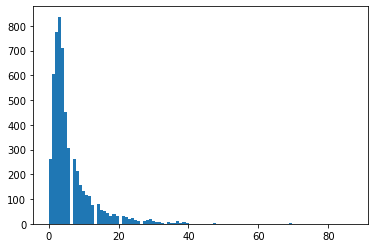

In [174]:
plt.show()
_ = plt.hist(ts, bins=100)

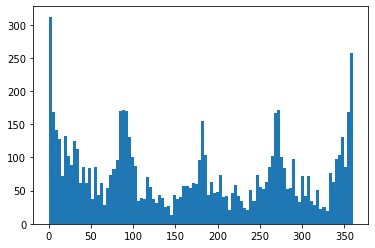

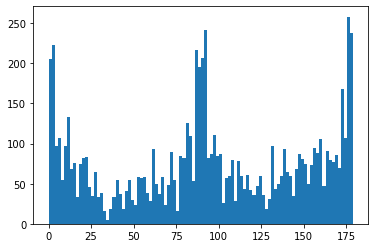

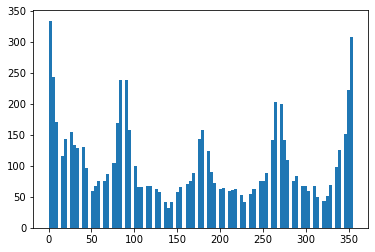

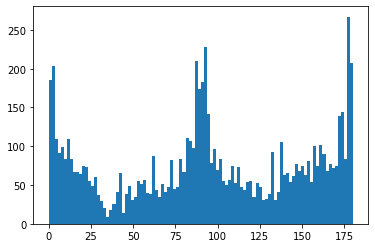

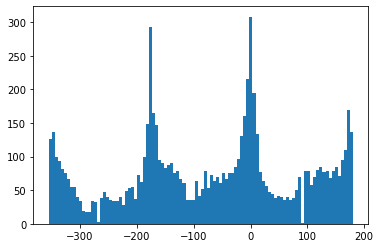

In [365]:
angle_pairs = np.array(angle_pairs)
plt.hist(angle_pairs[:, 0], bins=100)
plt.show()
_ = plt.hist(angle_pairs[:, 1], bins=100)
plt.show()
_ = plt.hist(angle_pairs[:, 2], bins=100)
plt.show()
_ = plt.hist(angle_pairs[:, 3], bins=100)
plt.show()
_ = plt.hist(angle_pairs[:, 4], bins=100)

In [117]:
import math

def convert_angle(points):
    points = np.array(list(points))
    points = [points[:2], points[2:4], points[4:6], points[6:8]]
    x,y,w,h,a = xy42xywha(points)
    return a

def rotate_around_point(origin, radians, point):
    """Rotate a point around a given point.

    I call this the "low performance" version since it's recalculating
    the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
    It's more readable than the next function, though.
    """
    x, y = point
    ox, oy = origin

    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

    return qx, qy

def get_points_and_angle(box):

    cx, cy = float(box['cx']), float(box['cy'])
    w2, h2 = float(box['w'])/2, float(box['h'])/2
    xlt = cx - w2; ylt = cy - h2
    xrt = cx + w2; yrt = cy - h2

    xlb = cx - w2; ylb = cy + h2
    xrb = cx + w2; yrb = cy + h2

    xlt, ylt = rotate_around_point((cx, cy), math.radians(box['angle']), (xlt, ylt))
    xrt, yrt = rotate_around_point((cx, cy), math.radians(box['angle']), (xrt, yrt))
    xlb, ylb = rotate_around_point((cx, cy), math.radians(box['angle']), (xlb, ylb))
    xrb, yrb = rotate_around_point((cx, cy), math.radians(box['angle']), (xrb, yrb))
    return (xlt, ylt, xrt, yrt, xrb, yrb, xlb, ylb, ), math.radians(box['angle'])

xml_files = list(glob.iglob(os.path.join('/home/mde/python/veolia-amr/data/annotated/all_annotated', '*.xml')))

for d in ['train', 'val', 'test']:
    for d2 in ['images', 'labelTxt']:
        p = os.path.join(d2, d)
        if not os.path.isdir(p):
            os.makedirs(p)

np.random.seed(42)
np.random.shuffle(xml_files)
for i, xml_file in enumerate(xml_files):
    print(i, len(xml_files))
    jpg_file = xml_file[:-4]+ '.jpg'
    xml_filename = ntpath.basename(xml_file)
    jpg_filename = xml_filename[:-4] + '.jpg'
    jpg_path = os.path.join('images/train', jpg_filename)
    if not os.path.isfile(jpg_path):
        continue
    txt_filename = xml_filename[:-4] + '.txt'
    
    box = get_xml_data(xml_file)
    points, _ = get_points_and_angle(box)
    angle = convert_angle(points)
#     label = ' '.join([str(x) for x in points]) + ' bar 0 ' + str(angle)
    print(jpg_filename)
    print('default points' , points)
    print('default angle', angle)
    img = Image.open(jpg_path)
    draw = ImageDraw.Draw(img)
    draw.line((*points[:2], *points[2:4]), fill='blue', width=10)
    draw.line((*points[2:4], *points[4:6]), fill='red', width=10)
    draw.line((*points[4:6], *points[6:8]), fill='red', width=10)
    draw.line((*points[6:8], *points[:2]), fill='red', width=10)
    
    points = np.array(list(points))
    points = [points[:2], points[2:4], points[4:6], points[6:8]]
    x,y,w,h,a = xy42xywha(points)
    print('xy42xywha x,y,w,h', x,y,w,h)
    print('xy42xywha angle', a)
    print(a, angle)
    points = xywha2xy4([x,y,w,h,a])
    print('xywha2xy4 points', points)
    print()
    l = 30
    draw.line((*points[0]+l, *points[1]+l), fill='blue', width=10)
    draw.line((*points[1]+l, *points[2]+l), fill='red', width=10)
    draw.line((*points[2]+l, *points[3]+l), fill='red', width=10)
    draw.line((*points[3]+l, *points[0]+l), fill='red', width=10)
    
    print(xywha)
    img = img.rotate(angle, center=(x,y))
    draw = ImageDraw.Draw(img)
    draw.rectangle((x-w/2, y-h/2, x+w/2, y+h/2), fill='green')
    img = img.rotate(-a, center=(x,y))
    
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()
    #create new
    # dest = None
    # if np.random.random() > 0.1:
    #     dest = 'train'
    # else:
    #     dest = 'val' if np.random.random() > 0.5 else 'test'

    #add angle
#     for dest in ['train', 'test', 'val']:
#         p = os.path.join('labelTxt', dest, txt_filename)
#         if os.path.isfile(p):
#             with open(p, 'w+') as f:
#                 f.write(label)
#                 f.close()

#     # with open(p, 'w+') as f:
#     #     f.write(label)
#     #     f.close()
#     o_dir = os.path.join('images', dest)
    
#     if not os.path.isdir(o_dir):
#         os.makedirs(o_dir)

#     new_img_path = os.path.join(o_dir, jpg_filename)
#     if not os.path.isfile(new_img_path):
#         # copyfile(jpg_file, new_img_path)
#         pass


0 2920
19632_1596707238603.jpg
default points (1764.3086009255674, 1722.375756896057, 1222.5979387664963, 1889.0016524440791, 1196.7259990744326, 1804.890443103943, 1738.4366612335036, 1638.264547555921)
default angle 162.90251847499678
xy42xywha x,y,w,h 1480.5173 1763.6331 566.7579999999996 88.00029999999994
xy42xywha angle 162.90251847499678
162.90251847499678 162.90251847499678
xywha2xy4 points [[1764.30860093 1722.3757569 ]
 [1222.59793877 1889.00165244]
 [1196.72599907 1804.8904431 ]
 [1738.43666123 1638.26454756]]



NameError: name 'xywha' is not defined

In [31]:
np.mean([[1764.3086009255674, 1722.375756896057, 1222.597-9387664963, 1889.0016524440791, 1196.7259990744326, 
         1804.890443103943, 1738.4366612335036, 1638.264547555921]], axis=0)


array([ 1.76430860e+03,  1.72237576e+03, -9.38766374e+09,  1.88900165e+03,
        1.19672600e+03,  1.80489044e+03,  1.73843666e+03,  1.63826455e+03])